In [ ]:
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import IPython.display as ipd
import torch

# Load audio
waveform, sample_rate = torchaudio.load("dataset/genea2023_dataset/trn/main-agent/wav/trn_2023_v0_000_main-agent.wav")  # (num_channels, num_samples)

waveform_np = waveform.mean(dim=0).numpy()  # Convert to mono if stereo

ipd.Audio(waveform_np, rate=sample_rate)

In [134]:
# Estimate pitch (F0)
pitch = F.detect_pitch_frequency(waveform, sample_rate)

print(pitch.shape)  # (num_frames,)
print(pitch)  # Hz values over time

torch.Size([1, 6485])
tensor([[1130.7693, 1130.7693, 1130.7693,  ...,  290.1316,  250.5682,
          250.5682]])


In [136]:
import librosa
onset_frames = librosa.onset.onset_detect(y=waveform_np, sr=sample_rate, backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)

print("Onset times (seconds):", onset_times)


Onset times (seconds): [ 0.23219955  0.90557823  1.3815873   2.13623583  2.43809524  2.62385488
  2.78639456  2.98376417  3.21596372  3.55265306  3.78485261  3.97061224
  4.17959184  4.36535147  4.48145125  4.77170068  4.81814059  5.03873016
  5.30575964  5.43346939  5.49151927  5.59600907  5.67727891  5.75854875
  5.9907483   6.38548753  7.14013605  7.24462585  7.60453515  7.7322449
  7.84834467  7.91800454  8.16181406  8.32435374  8.44045351  8.48689342
  8.63782313  8.67265306  9.22993197  9.50857143 11.09913832 11.3661678
 11.49387755 11.77251701 11.85378685 11.92344671 12.01632653 12.07437642
 12.19047619 12.30657596 12.42267574 13.54884354 13.78104308 13.78104308
 13.86231293 13.9784127  14.03646259 14.22222222 14.338322   14.39637188
 14.4892517  14.68662132 15.09297052 15.2555102  15.39482993 16.35845805
 16.40489796 16.54421769 16.81124717 17.02022676 17.11310658 17.18276644
 17.62394558 17.87936508 18.00707483 18.28571429 18.41342404 18.47147392
 18.71528345 18.77333333 18.80

In [138]:
frame_size = int(sample_rate * 0.05)  # 50ms frames
energy = waveform.unfold(1, frame_size, frame_size).pow(2).sum(dim=2)

print(energy.shape)  # (1, num_frames)
print(energy)

torch.Size([1, 1300])
tensor([[ 9.8958, 10.1538,  9.7158,  ...,  9.9603,  9.9166,  9.8908]])


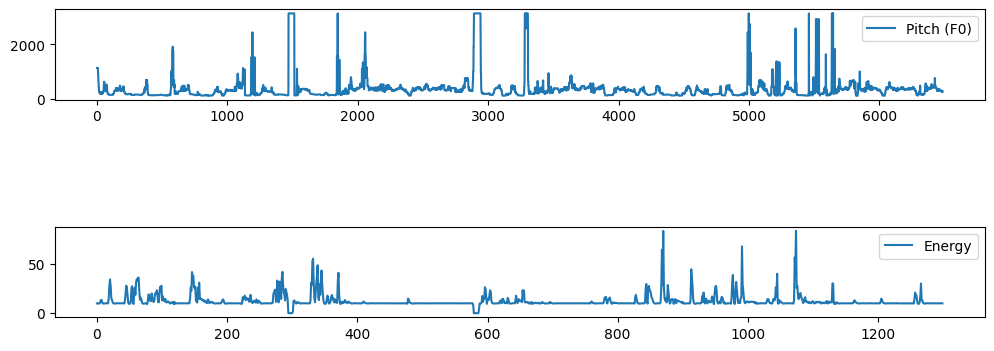

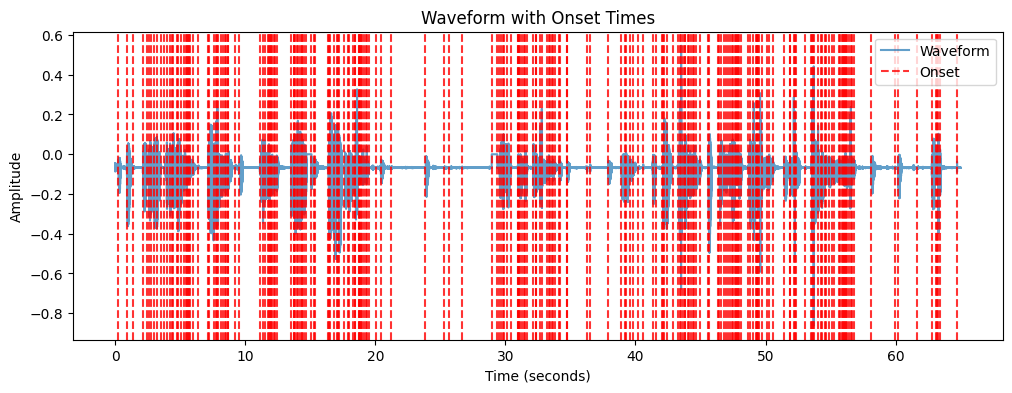

In [139]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 4))

plt.subplot(3, 1, 1)
plt.plot(pitch[0].numpy(), label="Pitch (F0)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(energy[0].numpy(), label="Energy")
plt.legend()

# Compute time axis for waveform
time_axis = np.linspace(0, len(waveform_np) / sample_rate, num=len(waveform_np))

# Compute onset times using Librosa
onset_frames = librosa.onset.onset_detect(y=waveform_np, sr=sample_rate, backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(time_axis, waveform_np, label="Waveform", alpha=0.7)

# Add vertical lines at onset times
for onset in onset_times:
    plt.axvline(x=onset, color='r', linestyle='--', alpha=0.8, label="Onset" if onset == onset_times[0] else "")

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform with Onset Times")
plt.legend()
plt.show()


plt.show()

In [ ]:
from transformers import WavLMModel, Wav2Vec2FeatureExtractor
import torch
import torchaudio
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")

# Load the pretrained model and feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base")
model = WavLMModel.from_pretrained("microsoft/wavlm-base")
model.to(device)

# Load an audio file (assumed to be mono, 16kHz)
waveform, wav_sample_rate = torchaudio.load("dataset/genea2023_dataset/trn/main-agent/wav/trn_2023_v0_000_main-agent.wav")
waveform = torchaudio.transforms.Resample(orig_freq=wav_sample_rate, new_freq=16000)(waveform)

# Split the audio into 5-second chunks and collect them into a batch
sample_rate = 16000  # WavLM expects 16kHz input
duration = 5  # seconds
segment_length = sample_rate * duration 
batch = []  # Store chunks

for start in range(0, len(waveform[0]), segment_length):
    chunk = waveform[0][start:start + segment_length]
    if len(chunk) < segment_length:  # Pad if needed
        chunk = torch.nn.functional.pad(chunk, (0, segment_length - len(chunk)))
    batch.append(chunk)

# Convert to tensor and process as batch
batch_tensor = torch.stack(batch)  # Shape: [batch_size, time_steps]
inputs = feature_extractor(batch_tensor, return_tensors="pt", sampling_rate=sample_rate)
inputs["input_values"] = inputs["input_values"].squeeze() # Remove extra dimension which is added by the feature extractor

# Batch processing does not work with WavLM because the attention mask is not automatically copied across batches when not supplied. 
# I believe this might be a bug. This line is a hacky way to manually construct the attention mask for the input
inputs["attention_mask"] = (inputs["input_values"] != 0)

# Extract WavLM embeddings
with torch.no_grad():
    inputs.to(device)
    outputs = model(**inputs)

embeddings = outputs.last_hidden_state  # Shape: [batch, time_steps, hidden_dim]
print(embeddings.shape)  # Example: [1, 500, 1024] (depends on audio length)

# Unfortunately wavlm extracts embeddings at 20ms intervals (50 fps), 
# so we need to downsample to match the sampling rate of the other features (30 fps)
# (This is an area for possible performance improvement in the future, possibly it is possible to finetune wavlm to extract embeddings at 30fps)
embeddings_downsampled = F.interpolate(embeddings.permute(0,2,1), size=(duration * 30,), mode="linear", align_corners=False).permute(0,2,1) # permutes are needed because interpolate always works on the last dimension (annoying). But performance impact should be negligible
print(embeddings_downsampled.shape) # ([13, 150, 768])

# Now I flatten the tensor to place each batch back one after each other. (How am I sure that it is being reconstructed in the right order?)
embeddings_flattened = embeddings_downsampled.flatten(start_dim=0, end_dim=1)
print(embeddings_flattened.shape) # ([1950, 768])


evaluating
torch.Size([13, 249, 768])
torch.Size([13, 150, 768])
torch.Size([1950, 768])


Considerations on the above:
This is based on the implementation in the original paper (with some simplification in implementation + batching)
One thing of note is that WavLM is applied to 5 second segments, processed individually and then joined again at the end.
What are the implications of this? Are the transitions between the 5 second segments reasonable and smooth? Another thing of note is that is is fairly slow to use wavlm to process the audio, even using the base model instead of the large model. (it takes about 3.5 seconds) granted, I am processing the entire wavlm which is over a minute long. And I am doing it on a m1 mac with mps, and some of the time is probably python boot up + loading the model etc etc. It is still maybe slightly concerning. 

In [1]:
import librosa

# Load audio file
y, sr = librosa.load("dataset/genea2023_dataset/trn/main-agent/wav/trn_2023_v0_000_main-agent.wav", sr=None)

# 1. Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=23)

# 2. MFCC
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)

# 3. Prosody Features
# - Pitch (F0)
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))

# - RMS Energy (loudness)
rms_energy = librosa.feature.rms(y=y)

# Print the shapes of the extracted features
print(f"Mel Spectrogram shape: {mel_spec.shape}")
print(f"MFCC shape: {mfcc.shape}")
print(f"Pitch (F0) shape: {f0.shape}")
print(f"RMS Energy shape: {rms_energy.shape}")

# This works but is very slow, it takes almost a minute to extract all the features


Mel Spectrogram shape: (23, 5599)
MFCC shape: (13, 5599)
Pitch (F0) shape: (5599,)
RMS Energy shape: (1, 5599)


In [ ]:
import torchaudio
import torch

# Load audio file (with `torchaudio`)
waveform, sample_rate = torchaudio.load("dataset/genea2023_dataset/trn/main-agent/wav/trn_2023_v0_000_main-agent.wav", normalize=True)

# 1. Mel Spectrogram
mel_spec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate, 
    n_fft=2048, 
    hop_length=512, 
    n_mels=23
)
mel_spec = mel_spec_transform(waveform)

# 2. MFCC
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate, 
    n_mfcc=16,  # Reduce to a number <= n_mels
    melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 23}  # 23 Mel bins
)
mfcc = mfcc_transform(waveform)

# 3. RMS Energy
rms_transform = torchaudio.transforms.Loudness(
    sample_rate=sample_rate
)
rms_energy = rms_transform(waveform)

# Print the shapes of the extracted features
print(f"Mel Spectrogram shape: {mel_spec.shape}")
print(f"MFCC shape: {mfcc.shape}")
print(f"RMS Energy shape: {rms_energy.shape}")

Mel Spectrogram shape: torch.Size([1, 23, 5599])
MFCC shape: torch.Size([1, 16, 5599])
RMS Energy shape: torch.Size([])
